In [4]:
import netCDF4 as nc4
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FixedLocator, FixedFormatter,
                               NullLocator)
import matplotlib.gridspec as gridspec

def makeitbig():
    # https://matplotlib.org/users/customizing.html
    params = {'legend.fontsize': 'x-large',
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    plt.rcParams.update(params)
    return(0)
makeitbig()

save = 0
def showsave(name, fig):
    if save:
        try:
            fig.savefig(name)
            print("saving : %s" % name)
            plt.close(fig)
        except:
            try:
                fig.show()
            except:
                plt.close(fig)
    else:
        plt.show()
        #fig.show()
    return()

In [5]:
""" mise en pli
"""
def prettydlonely(ax0):

    ax0.set_ylim(5000,0)
    ax0.set_yticks([0,500, 1000,1500,2000,2500,3000,3500,4000,4500,5000])
    ax0.set_yticklabels(["0","","1000","","2000","","3000","","4000","","5000"])
    ax0.set_ylabel("depth (m)")

    ax0.patch.set_color('.25')
    ax0.tick_params(axis = "y", width=1.5, length = 7, labelsize = 16, pad = 5)
    ax0.tick_params(axis = 'x', width=1.5, length = 7, labelsize = 16, pad = 10)
    ax0.grid(axis="y", alpha=.8, linewidth=1, linestyle=":")
    ax0.grid(axis="x", alpha=.8, linewidth=1, linestyle=":")
    return(ax0)

""" MinMax pour cbar
"""
# thanks https://deusyss.developpez.com/tutoriels/Python/args_kwargs/
def minmax(*args):
    a = [np.nanmin(_) for _ in args]
    b = [np.nanmax(_) for _ in args]
    return(np.min(a),np.max(b))

In [ ]:
dirdt = "/linkhome/rech/genloc01/ukd13rj/global_diag/caz_output"


""" o2tmx1v1
"""
psstytmx1v1 = dirdt+"/o2tmx1v1/o2tmx1v1_04910101_05001231_1Y_grid_V.nc"
sstytmx1v1 = nc4.Dataset(psstytmx1v1)
vctreff_tmx1v1=sstytmx1v1.variables['vocetr_eff'][9] # moyenne sur la derniere année
e3v_tmx1v1=sstytmx1v1.variables['e3v'][9]

""" o2tmx2v1
"""
psstytmx2v1 = dirdt+"/o2tmx2v1/o2tmx2v1_04910101_05001231_1Y_grid_V.nc"
sstytmx2v1 = nc4.Dataset(psstytmx2v1)
vctreff_tmx2v1=sstytmx2v1.variables['vocetr_eff'][9] # moyenne sur la derniere année

""" o2tmx3v1
"""
psstytmx3v1 = dirdt+"/o2tmx3v1/o2tmx3v1_04910101_05001231_1Y_grid_V.nc"
sstytmx3v1 = nc4.Dataset(psstytmx3v1)
vctreff_tmx3v1=sstytmx3v1.variables['vocetr_eff'][9] # moyenne sur la derniere année

""" latitude/longitude """
lon = np.array(sstytmx3v1.variables['nav_lon'])
lat = np.array(sstytmx3v1.variables['nav_lat'])


""" atlantic """
pmask = dirdt+"/MASK/x.nc"
dmask = nc4.Dataset(pmask)
mask_atl = dmask.variables['atlmsk_nomed'][0]

""" fin arctic, galère à incorporer"""
mask_pcf = dmask.variables['pacmsk'][0]
mask_art = mask_pcf[125:,:]

""" mask """
pmask = dirdt+"/MASK/mesh_mask_partial.nc"
dmask = nc4.Dataset(pmask)
vmaska = dmask.variables['vmask'][0]

pobs = dirdt+"/CLIMATOLOGIES/potT_annual_mean.nc"
dobs = nc4.Dataset(pobs)
depth = np.array(dobs.variables['depth'])

mask_atl[:,180:] = 0   # recouvrement périodique
mask_atl[148,:]  = 0    # poles
mask_atl[147,91] = 0


""" section latitude """
j1 = 45 ; j2 = 149 ; jlim = 46
mask_atl[:j1,:] = 0
mask_atl[j2:,:] = 0

# mask_atl[:35,:] = 0   # on coupe à 50S
# mask_atl[:45,:] = 0   # on coupe à 35S
# mask_atl[130:,:] = 0   # point critique au dela de 70N, saut dans lat/lon
# mask_atl[118:,:] = 0   # point critique au dela de 60N, saut dans lat/lon


""" Fcur meridien """
vmask = np.logical_and(vmaska==1,mask_atl==1)

latm = np.ma.masked_array(data=lat)
latm = np.ma.masked_where(vmask[0]==0,lat)

# bof
# latm = np.ma.masked_where(vmask[0]==0,lat)
# latx = np.mean(latm,axis=1)
pole = np.where(np.abs(lat[-1,:]-90)/90<0.015)[0][-1]
latx = lat[:,pole]

In [ ]:

""" **************************************************************
    CALCUL FONCTION DE COURANT
"""
""" fonction de courant méridionale
    k : range : 0-29 intégration de 29 (le fond est 30 mask=0) à k.
        k=0 est tot (z=surface)
        k=30 c'est zéro (z=fond),
    la pondération est déjà effectuée
"""

# def sum_sfm(dtarray, e3v):
#     K,J,I = np.shape(dtarray)
#     dtout = np.zeros((K,J)) # np.masked_array(data = np.zeros((K,J)))
#     e3vout = np.zeros((K,J))
#     for k in range(K):
#         # dtout = np.ma.masked_where(vmask[k]==0, dtout)
#         for j in range(J):
#             dtout[k,j] = - np.sum(dtarray[k:,j,:]*vmask[k:,j,:])/1E6
#             # somme cumulé depuis le fond des e3v, moyenné méridiennement (bof mais bon)
#             e3vout[k,j] = np.sum(e3v[k:,j,:])
#     return((dtout,e3vout))
#
# v_med_tmx1, e3v_tmx1 = sum_sfm(vctreff_tmx1v1, e3v_tmx1v1)
# x,_ = np.meshgrid(latx, e3v_tmx1[:,0])

""" tmx1
"""
""" mask + atl """
vm_tmx1 = np.ma.masked_array(data=vctreff_tmx1v1)
for k in range(31):
    vm_tmx1[k] = np.ma.masked_where(vmask[k]==0,vctreff_tmx1v1[k])
""" fonction de courant méridionale """
v_med_tmx1 = np.zeros((31,149))
for k in range(31):
    for j in range(149):
        # n = np.sum(mask[k,j,:])
        v_med_tmx1[k,j] = - np.sum(vm_tmx1[k:,j,:]*vmask[k:,j,:])/1E6

""" tmx2
"""
""" mask + atl """
vm_tmx2 = np.ma.masked_array(data=vctreff_tmx2v1)
for k in range(31):
    vm_tmx2[k] = np.ma.masked_where(vmask[k]==0,vctreff_tmx2v1[k])

""" fonction de courant méridionale """
v_med_tmx2 = np.zeros((31,149))
for k in range(31):
    for j in range(149):
        # n = np.sum(mask[k,j,:])
        v_med_tmx2[k,j] = - np.sum(vm_tmx2[k:,j,:]*vmask[k:,j,:])/1E6

""" tmx3
"""
""" mask + atl """
vm_tmx3 = np.ma.masked_array(data=vctreff_tmx3v1)
for k in range(31):
    vm_tmx3[k] = np.ma.masked_where(vmask[k]==0,vctreff_tmx3v1[k])

""" fonction de courant méridionale """
v_med_tmx3 = np.zeros((31,149))
for k in range(31):
    for j in range(149):
        # n = np.sum(mask[k,j,:])
        v_med_tmx3[k,j] = - np.sum(vm_tmx3[k:,j,:]*vmask[k:,j,:])/1E6


""" Test intégrale du fond à la surface est nulle
"""

fig, ax = plt.subplots(1,1,figsize=[6.4, 4.8],dpi=80)
""" méridional """
ax.plot(latx, v_med_tmx1[0,:],
        label = r'v_med_tmx1',
        marker = 'o',
        color = 'black', linestyle = '-', linewidth = 1.5)
ax.title.set_text('atlantic - fc meridional at z=0')

ax.set_xlabel("latitude")
ax.axvline(x=latx[j1], color = 'r', lw = 1.5)
ax.axvline(x=latx[j2-1], color = 'r', lw = 1.5)
ax.tick_params(which='both', width=2, length = 8, labelsize = 14)
ax.set_ylabel(r"sv")
ax.grid(axis="y", alpha=.3, linewidth=1, linestyle=":")
ax.grid(axis="x", alpha=.8, linewidth=1, linestyle=":")
plt.subplots_adjust(wspace = 0.3)
plt.tight_layout()
#plt.show()
showsave("fig/sf/sfm_atl_test.png", fig)


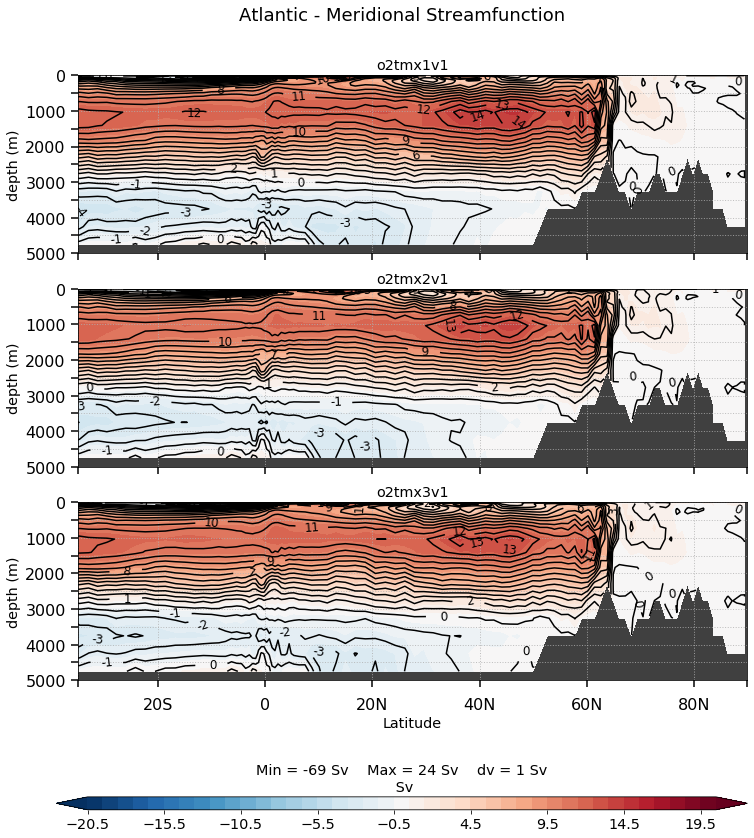

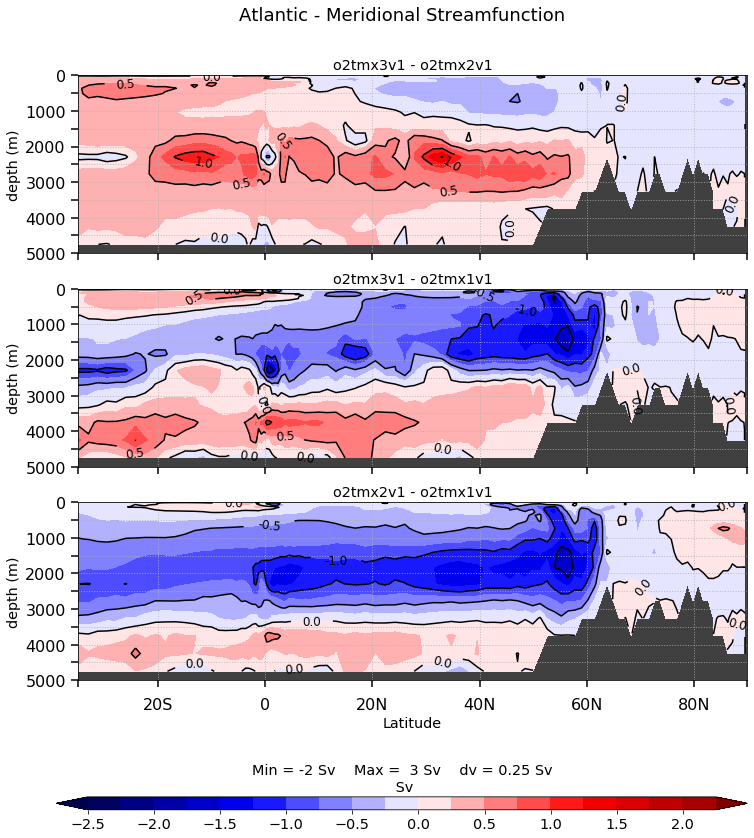

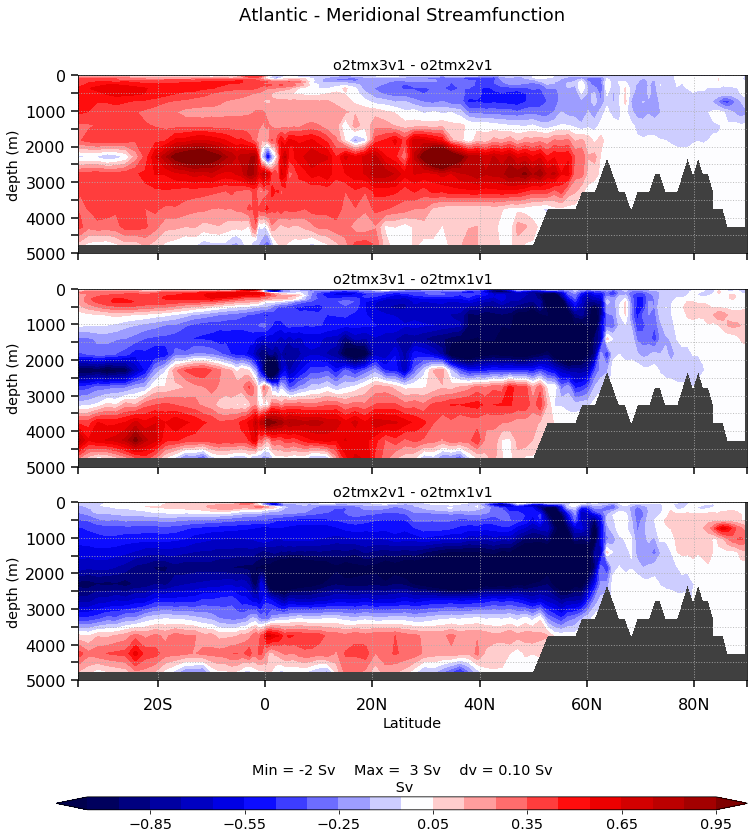

()

In [11]:
"""
    *************************************
    *    MERIDIONAL CURRENT FONCTION    *
    *************************************

    Fonction de courant méridionale (Y,Z) de tmx1,2,3 (v1)
"""

vmi = -20. ; vma = 20. ; dv = 1.
vmin= vmi - dv/2 ; vmax = vma + dv/2
levels = np.arange(vmin,vmax+dv,dv)
levelc = np.arange(vmi,vma,1)

# palette = plt.get_cmap('RdYlBu_r')
palette = plt.get_cmap('RdBu_r')
x,y = np.meshgrid(latx, depth[:31])

fig = plt.figure(figsize=(12, 12))
outer = gridspec.GridSpec(3, 1, hspace=0.2)

""" o2tmx1v1 """
ax0 = plt.Subplot(fig, outer[0])

cf1 = ax0.contourf(x, y,
                  v_med_tmx1,
                  levels = levels, vmin=vmin,vmax=vmax,
                  cmap = palette,
                  extend="both")
c1 = ax0.contour(x,y,
                v_med_tmx1,
                #linewidth =1, inline = 1, 
                 colors=('k',), linestyles = "solid",
                levels = levelc, vmin=vmin,vmax=vmax)
ax0.clabel(c1, fmt='%2.0f', colors='k', fontsize=12)
ax0.title.set_text('o2tmx1v1')
ax0.set_xlim(-35.,90.)
ax0.set_xticks([-35.,-20.,0.,20.,40.,60.,80.,90.])
ax0.tick_params(labelbottom=False)
ax0 = prettydlonely(ax0)
fig.add_subplot(ax0)

#
""" o2tmx2v1 """
ax0 = plt.Subplot(fig, outer[1])

cf1 = ax0.contourf(x, y,
                  v_med_tmx2,
                  levels = levels, vmin=vmin,vmax=vmax,
                  cmap = palette,
                  extend="both")
c1 = ax0.contour(x,y,
                v_med_tmx2,
                #linewidth =1, inline = 1,
                 colors=('k',), linestyles = "solid",
                levels = levelc, vmin=vmin,vmax=vmax)
ax0.clabel(c1, fmt='%2.0f', colors='k', fontsize=12)
ax0.title.set_text('o2tmx2v1')
ax0 = prettydlonely(ax0)
ax0.set_xlim(-35.,90.)
ax0.set_xticks([-35.,-20.,0.,20.,40.,60.,80.,90.])
ax0.tick_params(labelbottom=False)
fig.add_subplot(ax0)

""" o2tmx3v1 """
ax0 = plt.Subplot(fig, outer[2])

cf1 = ax0.contourf(x, y,
                  v_med_tmx3,
                  levels = levels, vmin=vmin,vmax=vmax,
                  cmap = palette,
                  extend="both")
c1 = ax0.contour(x,y,
                v_med_tmx3,
                #linewidth =1, inline = 1,
                  colors=('k',), linestyles = "solid",
                levels = levelc, vmin=vmin,vmax=vmax)
ax0.clabel(c1, fmt='%2.0f', colors='k', fontsize=12)
ax0.title.set_text('o2tmx3v1')
ax0 = prettydlonely(ax0)
ax0.set_xlim(-35.,90.)
ax0.set_xticks([-35.,-20.,0.,20.,40.,60.,80.,90.])
ax0.tick_params(labelbottom=True)
fig.add_subplot(ax0)


""" x ticks
"""
ax0.set_xticklabels(["","20S","0","20N","40N","60N","80N",""])
ax0.set_xlabel("Latitude")

""" colorbar
"""
fig.subplots_adjust(bottom=0.2, top = 0.9, hspace = 0.25, wspace = 0.2)
cax = fig.add_axes([0.1, 0.05, 0.8, 0.015])
cbar = plt.colorbar(cf1,cax=cax,
                    orientation = "horizontal")

(a,b) = minmax(v_med_tmx1,v_med_tmx1,v_med_tmx1)
cbar.ax.set_title('Min = %2.0f Sv    Max = %2.0f Sv    dv = %1.0f Sv' % (a,b, dv) + '\n Sv', y=1.02)

plt.suptitle('Atlantic - Meridional Streamfunction', fontsize = 18)
showsave("fig/sf/sfm_atl.png", fig)




""" ************************************************************************
    ***********************************************************************
    Difference
    Fonction de courant méridionale (Y,Z) de tmx1,2,3 (v1)
"""

vmin = -2.5 ; vmax = 2.5 ; dv = 0.25
# vmin= vmi - dv/2 ; vmax = vma + dv/2
levels = np.arange(vmin,vmax,dv)
levelc = np.arange(vmin,vmax,0.5)
palette = plt.get_cmap('seismic')
x,y = np.meshgrid(latx, depth[:31])

fig = plt.figure(figsize=(12, 12))
outer = gridspec.GridSpec(3, 1, hspace=0.2)

""" o2tmx1v1 """
ax0 = plt.Subplot(fig, outer[0])

cf1 = ax0.contourf(x, y,
                  v_med_tmx3 - v_med_tmx2,
                  levels = levels, vmin=vmin,vmax=vmax,
                  cmap = palette,
                  extend="both")
c1 = ax0.contour(x,y,
                v_med_tmx3 - v_med_tmx2,
                #linewidth =1, inline = 1,
                  colors=('k',), linestyles = "solid",
                levels = levelc, vmin=vmin,vmax=vmax)
ax0.clabel(c1, fmt='%1.1f', colors='k', fontsize=12)

ax0.title.set_text('o2tmx3v1 - o2tmx2v1')
ax0 = prettydlonely(ax0)
ax0.set_xlim(-35.,90.)
ax0.set_xticks([-35.,-20.,0.,20.,40.,60.,80.,90.])
ax0.tick_params(labelbottom=False)
fig.add_subplot(ax0)




""" o2tmx2v1 """
ax0 = plt.Subplot(fig, outer[1])


cf1 = ax0.contourf(x, y,
                  v_med_tmx3 - v_med_tmx1,
                  levels = levels, vmin=vmin,vmax=vmax,
                  cmap = palette,
                  extend="both")
c1 = ax0.contour(x,y,
                v_med_tmx3 - v_med_tmx1,
                #linewidth =1, inline = 1,
                 colors=('k',), linestyles = "solid",
                levels = levelc, vmin=vmin,vmax=vmax)
ax0.clabel(c1, fmt='%1.1f', colors='k', fontsize=12)

ax0.title.set_text('o2tmx3v1 - o2tmx1v1')
ax0 = prettydlonely(ax0)
ax0.set_xlim(-35.,90.)
ax0.set_xticks([-35.,-20.,0.,20.,40.,60.,80.,90.])
ax0.tick_params(labelbottom=False)
fig.add_subplot(ax0)

""" o2tmx3v1 """
ax0 = plt.Subplot(fig, outer[2])

cf1 = ax0.contourf(x, y,
                  v_med_tmx2 - v_med_tmx1,
                  levels = levels, vmin=vmin,vmax=vmax,
                  cmap = palette,
                  extend="both")
c1 = ax0.contour(x,y,
                v_med_tmx2 - v_med_tmx1,
                #linewidth =1, inline = 1, 
                 colors=('k',), linestyles = "solid",
                levels = levelc, vmin=vmin,vmax=vmax)
ax0.clabel(c1, fmt='%1.1f', colors='k', fontsize=12)

ax0.title.set_text('o2tmx2v1 - o2tmx1v1')
ax0 = prettydlonely(ax0)
ax0.set_xlim(-35.,90.)
ax0.set_xticks([-35.,-20.,0.,20.,40.,60.,80.,90.])
ax0.tick_params(labelbottom=True)
fig.add_subplot(ax0)

""" x ticks
"""
ax0.set_xticklabels(["","20S","0","20N","40N","60N","80N",""])
ax0.set_xlabel("Latitude")

""" colorbar
"""
fig.subplots_adjust(bottom=0.2, top = 0.9, hspace = 0.25, wspace = 0.2)
cax = fig.add_axes([0.1, 0.05, 0.8, 0.015])
cbar = plt.colorbar(cf1,cax=cax,
                    orientation = "horizontal")

(a,b) = minmax(v_med_tmx3 - v_med_tmx3,v_med_tmx3 - v_med_tmx1,v_med_tmx2 - v_med_tmx1)
cbar.ax.set_title('Min = %2.0f Sv    Max = %2.0f Sv    dv = %1.2f Sv' % (a,b, dv) + '\n Sv', y=1.02)

plt.suptitle('Atlantic - Meridional Streamfunction', fontsize = 18)
showsave("fig/sf/sfm_atldiff.png", fig)



""" ************************************************************************
    ***********************************************************************
    Difference
    Fonction de courant méridionale (Y,Z) de tmx1,2,3 (v1)
"""

vmi = -1. ; vma = 1. ; dv = 0.1
vmin= vmi - dv/2 ; vmax = vma + dv/2
levels = np.arange(vmin,vmax,dv)
palette = plt.get_cmap('seismic')
x,y = np.meshgrid(latx, depth[:31])

fig = plt.figure(figsize=(12, 12))
outer = gridspec.GridSpec(3, 1, hspace=0.2)

""" o2tmx1v1 """
ax0 = plt.Subplot(fig, outer[0])

cf1 = ax0.contourf(x, y,
                  v_med_tmx3 - v_med_tmx2,
                  levels = levels, vmin=vmin,vmax=vmax,
                  cmap = palette,
                  extend="both")
# c1 = ax0.contour(x,y,
#                 v_med_tmx3 - v_med_tmx2,
#                 linewidth =1, colors=('k',), inline = 1, linestyles = "solid",
#                 levels = levelc, vmin=vmin,vmax=vmax)
# ax0.clabel(c1, fmt='%1.1f', colors='white', fontsize=12)

ax0.title.set_text('o2tmx3v1 - o2tmx2v1')
ax0 = prettydlonely(ax0)
ax0.set_xlim(-35.,90.)
ax0.set_xticks([-35.,-20.,0.,20.,40.,60.,80.,90.])
ax0.tick_params(labelbottom=False)
fig.add_subplot(ax0)
#
""" o2tmx2v1 """
ax0 = plt.Subplot(fig, outer[1])

cf1 = ax0.contourf(x, y,
                  v_med_tmx3 - v_med_tmx1,
                  levels = levels, vmin=vmin,vmax=vmax,
                  cmap = palette,
                  extend="both")
# c1 = ax0.contour(x,y,
#                 v_med_tmx3 - v_med_tmx1,
#                 linewidth =1, colors=('k',), inline = 1, linestyles = "solid",
#                 levels = levelc, vmin=vmin,vmax=vmax)
# ax0.clabel(c1, fmt='%1.1f', colors='white', fontsize=12)

ax0.title.set_text('o2tmx3v1 - o2tmx1v1')
ax0 = prettydlonely(ax0)
ax0.set_xlim(-35.,90.)
ax0.set_xticks([-35.,-20.,0.,20.,40.,60.,80.,90.])
ax0.tick_params(labelbottom=False)
fig.add_subplot(ax0)

""" o2tmx3v1 """
ax0 = plt.Subplot(fig, outer[2])

cf1 = ax0.contourf(x, y,
                  v_med_tmx2 - v_med_tmx1,
                  levels = levels, vmin=vmin,vmax=vmax,
                  cmap = palette,
                  extend="both")
# c1 = ax0.contour(x,y,
#                 v_med_tmx2 - v_med_tmx1,
#                 linewidth =1, colors=('k',), inline = 1, linestyles = "solid",
#                 levels = levelc, vmin=vmin,vmax=vmax)
# ax0.clabel(c1, fmt='%1.1f', colors='white', fontsize=12)

ax0.title.set_text('o2tmx2v1 - o2tmx1v1')
ax0 = prettydlonely(ax0)
ax0.set_xlim(-35.,90.)
ax0.set_xticks([-35.,-20.,0.,20.,40.,60.,80.,90.])
ax0.tick_params(labelbottom=True)
fig.add_subplot(ax0)

""" x ticks
"""
ax0.set_xticklabels(["","20S","0","20N","40N","60N","80N",""])
ax0.set_xlabel("Latitude")

""" colorbar
"""
fig.subplots_adjust(bottom=0.2, top = 0.9, hspace = 0.25, wspace = 0.2)
cax = fig.add_axes([0.1, 0.05, 0.8, 0.015])
cbar = plt.colorbar(cf1,cax=cax,
                    orientation = "horizontal")

(a,b) = minmax(v_med_tmx3 - v_med_tmx3,v_med_tmx3 - v_med_tmx1,v_med_tmx2 - v_med_tmx1)
cbar.ax.set_title('Min = %2.0f Sv    Max = %2.0f Sv    dv = %1.2f Sv' % (a,b, dv) + '\n Sv', y=1.02)

plt.suptitle('Atlantic - Meridional Streamfunction', fontsize = 18)
showsave("fig/sf/sfm_atldiffp.png", fig)
